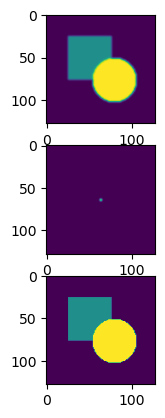

In [4]:
import numpy as np
from numpy.linalg import solve
from PIL import Image
from scipy.signal import convolve2d
from scipy.fft import idctn, dctn, fft2, ifft2
from matplotlib import pyplot as plt

import sys

from util.images import *


def get_img(path):
    pil_image = Image.open(path)
    dtype = {'F': np.float32, 'L': np.uint8}[pil_image.mode]
    np_image = np.array(pil_image.getdata(), dtype=dtype)
    w, h = pil_image.size
    np_image.shape = (h, w)
    return np_image, h, w


def gen_zero_bc(img, h, w):
    zero_bc_ud = np.zeros([h, w * 3])
    zero_bc = np.zeros([h, w])
    c_stack = np.hstack([zero_bc, img, zero_bc])
    X_ext = np.vstack([zero_bc_ud, c_stack, zero_bc_ud])
    return X_ext


def circshift(PSF, center):
    return np.roll(np.roll(PSF, -center[0], axis=0), -center[1], axis=1)


def dctshift(PSF, center):
    i = center[0]
    j = center[1]
    m, n = PSF.shape
    k = min([i, j, m - i, n - j])
    PP = PSF[i - k:i + k, j - k:j + k]
    Z1 = np.diag(np.ones(k), k)
    Z2 = np.diag(np.ones(k - 1), k + 1)

    PP = Z1 @ PP @ Z1.T \
        + Z1 @ PP @ Z2.T \
        + Z2 @ PP @ Z1.T \
        + Z2 @ PP @ Z2.T

    Ps = np.zeros([m, n])
    Ps[0:2 * k, 0:2 * k] = PP

    return Ps


def psf_gauss(dim, s):
    x = np.arange(0, dim[0])
    y = np.arange(0, dim[1])
    X, Y = np.meshgrid(x, y)
    inv_c = s ** -2
    x_shift = dim[0] // 2
    y_shift = dim[1] // 2
    matrix_product = inv_c * ((X - x_shift) ** 2 + (Y - y_shift) ** 2)
    return np.exp(-0.5 * matrix_product)


def dct_blur(S, X):
    return idctn(S * dctn(X))


def fft_blur(S, X):
    return np.real(ifft2(S * fft2(X)))


def generate_noisy_image():
    img, h, w = get_img()
    X_ext = gen_zero_bc(img, h, w)

    P = psf_gauss([w, h], 15)

    B_ext = convolve2d(X_ext, P, 'same')
    B = B_ext[h:2 * h, w:2 * w]
    return P, np.array([w / 2, h / 2]), B


def naive_deblur(PSF, center, B):
    e1 = np.zeros(PSF.shape)
    e1[0][0] = 1
    DCT_S = dctn(dctshift(PSF, center))
    S = solve(DCT_S, dctn(e1))

    return idctn(solve(dctn(B), S))


def naive_slow_deblur(PSF, center, B):
    S = fft2(np.roll(np.roll(PSF, -center[0], axis=0), -center[1], axis=1))

    # if any singular values are zero, adjust them to be the smallest possible decimal number instead
    # prevents divide by zero errors
    S = np.where(S != 0, S, sys.float_info.min)
    
    B_1 = fft2(B) / S
    B_2 = ifft2(B_1)
    return np.real(B_2)

def fft_demo():
    SF = 3
    img, h, w = get_img()
    X_ext = gen_zero_bc(img, h, w)
    PSF = psf_gauss([w * 3, h * 3], SF)
    center = [int(w * 1.5), int(w * 1.5)]
    S = fft2(circshift(PSF, center))
    B_ext = fft_blur(S, X_ext)
    B = B_ext[h:2 * h, w:2 * w]
    plt.subplot(311)
    plt.imshow(B)

    N_PSF = psf_gauss([w, h], SF)

    plt.subplot(312)
    plt.imshow(N_PSF)


    center = [int(w * 0.5), int(w * 0.5)]
    deblurred = naive_slow_deblur(N_PSF, center, B)
    plt.subplot(313)
    plt.imshow(deblurred)
    plt.show()


    #  P, center, B = generate_noisy_image()
    #  plt.imshow(B)
    #  plt.show()


def dct_demo():
    SF = 0.00001
    img, h, w = get_img()
    X_ext = gen_zero_bc(img, h, w)
    PSF = psf_gauss([w * 3, h * 3], SF)
    center = [int(w * 1.5), int(w * 1.5)]

    e1 = np.zeros(PSF.shape)
    e1[0][0] = 1
    S = dctn(dctshift(PSF, center)) / dctn(e1)

    B_ext = dct_blur(S, X_ext)
    B = B_ext[h:2 * h, w:2 * w]
    plt.subplot(411)
    plt.imshow(B)

    N_PSF = psf_gauss([w, h], SF)

    plt.subplot(412)
    plt.imshow(N_PSF)

    center = [int(w * 0.5), int(w * 0.5)]
    deblurred = naive_deblur(N_PSF, center, B)
    plt.subplot(413)
    plt.imshow(deblurred)

    plt.subplot(414)
    plt.imshow(S)
    plt.show()


SF = 5
img, h, w = get_img('samples/shapes.png')
X_ext = gen_zero_bc(img, h, w)
PSF = psf_gauss([w * 3, h * 3], SF)
center = [int(w * 1.5), int(w * 1.5)]
S = fft2(circshift(PSF, center))
# blur
B_ext = fft_blur(S, X_ext)
B = B_ext[h:2 * h, w:2 * w]
save_img_raw(B, 'results/blurred.png')
# normalize B
# B = B / B.max()
plt.subplot(311)
plt.imshow(B)
N_PSF = psf_gauss([w, h], SF)
plt.subplot(312)
plt.imshow(N_PSF)
center = [int(w * 0.5), int(w * 0.5)]
deblurred = naive_slow_deblur(N_PSF, center, B)
save_img_raw(deblurred, 'results/deblurred.png')
plt.subplot(313)
plt.imshow(deblurred)
plt.show()